<a href="https://colab.research.google.com/github/thayyilakul/PyTorch-ML/blob/main/Movie_recommendation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import torch
torch.__version__

'2.5.1+cu121'

In [3]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [4]:
import pandas as pd

df = pd.read_csv('/content/gdrive/MyDrive/ratings.csv')
df.head()

,userId,movieId,rating,timestamp
0,1,1,4.0,964982703
1,1,3,4.0,964981247
2,1,6,4.0,964982224
3,1,47,5.0,964983815
4,1,50,5.0,964982931


In [5]:
len(df)

100836

In [6]:
from torch.utils.data import Dataset

class MovieLensDataset(Dataset):
  def __init__(self, users, movies, ratings):
    self.users = users
    self.movies = movies
    self.ratings = ratings

  def __len__(self):
    return len(self.users)

  def __getitem__(self, item):
    users = self.users[item]
    movies = self.movies[item]
    ratings = self.ratings[item]
    return {
        'users' : torch.tensor(users, dtype = torch.long),
        'movies' : torch.tensor(movies, dtype = torch.long),
        'ratings' : torch.tensor(ratings, dtype = torch.long),
    }

In [7]:
from torch import nn

class RecommendationSystemModel(nn.Module):
  def __init__(self, num_users, num_movies, embedding_size = 256, hidden_dim = 256, dropout_rate = 0.2):
    super().__init__()
    self.num_users = num_users
    self.num_movies = num_movies
    self.embedding_size = embedding_size
    self.hidden_dim = hidden_dim

    self.user_embedding = nn.Embedding(num_embeddings = self.num_users, embedding_dim = self.embedding_size)
    self.movie_embedding = nn.Embedding(num_embeddings = self.num_movies, embedding_dim = self.embedding_size)

    self.fc1 = nn.Linear(2 * self.embedding_size, self.hidden_dim)
    self.fc2 = nn.Linear(self.hidden_dim, 1)

    self.dropout = nn.Dropout(p = dropout_rate)

    self.relu = nn.ReLU()

  def forward(self, users, movies):
    user_embedded = self.user_embedding(users)
    movie_embedded = self.movie_embedding(movies)

    combined = torch.cat([user_embedded, movie_embedded], dim = 1)

    x = self.relu(self.fc1(combined))
    x = self.dropout(x)
    output = self.fc2(x)
    return output

In [8]:
from sklearn import preprocessing

le_user = preprocessing.LabelEncoder()
le_movie = preprocessing.LabelEncoder()
df.userId = le_user.fit_transform(df.userId.values)
df.movieId = le_movie.fit_transform(df.movieId.values)

In [9]:
from sklearn.model_selection import train_test_split

df_train, df_val = train_test_split(df, test_size = 0.2, random_state = 3, stratify = df.rating.values)

In [10]:
train_dataset = MovieLensDataset(
    users = df_train.userId.values,
    movies = df_train.movieId.values,
    ratings = df_train.rating.values,
)

valid_dataset = MovieLensDataset(
    users = df_val.userId.values,
    movies = df_val.movieId.values,
    ratings = df_val.rating.values,
)

In [11]:
from torch.utils.data import DataLoader

BATCH_SIZE = 32

train_loader = DataLoader(train_dataset, batch_size = BATCH_SIZE, shuffle = True, num_workers = 8)
val_loader = DataLoader(valid_dataset, batch_size = BATCH_SIZE, shuffle = True, num_workers = 8)

/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


In [12]:
recommendation_model = RecommendationSystemModel(
    num_users = len(le_user.classes_),
    num_movies = len(le_movie.classes_),
    embedding_size = 64,
    hidden_dim = 128,
    dropout_rate = 0.1
).to('cpu')

optimizer = torch.optim.Adam(recommendation_model.parameters(), lr = 1e-3)
loss_func = nn.MSELoss()

In [13]:
import sys

EPOCHS = 2

def log_progress(epoch, step, total_loss, log_progress_step, data_size, losses):
  avg_loss = total_loss / log_progress_step
  sys.stderr.write(f'\r{epoch+1:02d}/{EPOCHS:02d} | Step : {step}/{data_size} | Avg Loss : {avg_loss:<6.9f}')
  sys.stderr.flush()
  losses.append(avg_loss)

In [14]:
total_loss = 0
log_progress_step = 100
losses = []
train_dataset_size = len(train_dataset)
print(f'Training on {train_dataset_size} samples...')

recommendation_model.train()
for e in range(EPOCHS):
  step_count = 0
  for i, train_data in enumerate(train_loader):
    output = recommendation_model(train_data['users'].to('cpu'), train_data['movies'].to('cpu'))
    output = output.squeeze()
    ratings = (train_data['ratings'].to(torch.float32).to('cpu'))
    loss = loss_func(output, ratings)
    total_loss += loss.sum().item()
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    step_count += len(train_data['users'])

    if (step_count & log_progress_step == 0 or i == len(train_loader) - 1):
      log_progress(e, step_count, total_loss, log_progress_step, train_dataset_size, losses)
      total_loss = 0

Training on 80668 samples...


/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
02/02 | Step : 80668/80668 | Avg Loss : 0.007254030

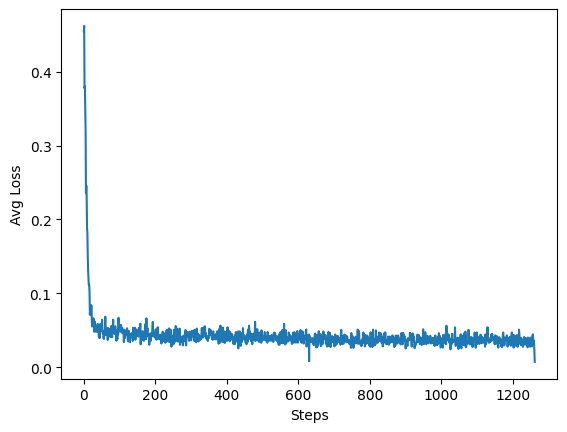

In [15]:
import matplotlib.pyplot as plt

plt.figure()
plt.plot(losses)
plt.xlabel('Steps')
plt.ylabel('Avg Loss')
plt.show()

In [16]:
import sklearn
from sklearn.metrics import mean_squared_error

y_pred = []
y_true = []

recommendation_model.eval()

with torch.no_grad():
  for i, valid_data in enumerate(val_loader):
    output = recommendation_model(
        valid_data['users'].to('cpu'),
        valid_data['movies'].to('cpu')
    )
    ratings = valid_data['ratings'].to('cpu')
    y_pred.extend(output.cpu().numpy())
    y_true.extend(ratings.cpu().numpy())

rms = mean_squared_error(y_true, y_pred)
print(f'RMSE: {rms:.4f}')

RMSE: 0.9168


In [17]:
from collections import defaultdict

def calculate_precision_recall(user_ratings, k, threshold):
  user_ratings.sort(key = lambda x : x[0], reverse = True)
  n_rel = sum(true_r >= threshold for _, true_r in user_ratings)
  n_rec_k = sum(est >= threshold for est, _ in user_ratings[:k])
  n_rel_and_rec_k = sum((true_r >= threshold) and (est >= threshold) for est, true_r in user_ratings[:k])

  precision = n_rel_and_rec_k / n_rec_k if n_rec_k != 0 else 1
  recall = n_rel_and_rec_k / n_rel if n_rel != 0 else 1
  return precision, recall

In [18]:
user_ratings_comparison = defaultdict(list)

with torch.no_grad():
  for valid_data in val_loader:
    users = valid_data['users'].to('cpu')
    movies = valid_data['movies'].to('cpu')
    ratings = valid_data['ratings'].to('cpu')
    output = recommendation_model(users, movies)

    for user, pred, true in zip(users, output, ratings):
      user_ratings_comparison[user.item()].append((pred[0].item(), true.item()))

user_precisions = dict()
user_based_recalls = dict()

/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


In [19]:
k = 50
threshold = 3

for user_id, user_ratings in user_ratings_comparison.items():
  precision, recall = calculate_precision_recall(user_ratings, k, threshold)
  user_precisions[user_id] = precision
  user_based_recalls[user_id] = recall

average_precision = sum(prec for prec in user_precisions.values()) / len(user_precisions)
average_recall = sum(prec for prec in user_based_recalls.values()) / len(user_based_recalls)

print(f'Precision @ {k}: {average_precision:.4f}')
print(f'Recall @ {k}: {average_recall:.4f}')

Precision @ 50: 0.8995
Recall @ 50: 0.8125


In [20]:
def recommend_top_movies(model, user_id, all_movies, seen_movies, device = 'cpu', k = 5, batch_size = 100):
  model.eval()
  unseen_movies = [m for m in all_movies if m not in seen_movies]
  predictions = []

  with torch.no_grad():
    for i in range(0, len(unseen_movies), batch_size):
      batch_unseen_movies = unseen_movies[i:i+batch_size]
      user_tensor = torch.tensor([user_id] * len(batch_unseen_movies)).to(device)
      movie_tensor = torch.tensor(batch_unseen_movies).to(device)
      predicted_ratings = model(user_tensor, movie_tensor).view(-1).tolist()
      predictions.extend(zip(batch_unseen_movies, predicted_ratings))

  predictions.sort(key = lambda x : x[1], reverse = True)
  top_k_movies = [movie_id for movie_id, _ in predictions[:k]]
  return top_k_movies

In [26]:
def get_movies_with_genres(movie_ids, df_movies):
  movies_with_genres = df_movies[df_movies['movieId'].isin(movie_ids)].copy()
  movies_with_genres['title_with_genres'] = movies_with_genres[['title', 'genres']].agg(' - '.join, axis = 1)
  return movies_with_genres['title_with_genres'].tolist()

df_movies = pd.read_csv('/content/gdrive/MyDrive/movies.csv')

all_movies = df['movieId'].unique().tolist()
user_id = 1
seen_movies = set(df[df['userId'] == user_id]['movieId'].tolist())

recommendations = recommend_top_movies(
    recommendation_model,
    user_id,
    all_movies,
    seen_movies,
    'cpu'
)

recommended_movies_with_genres = get_movies_with_genres(recommendations, df_movies)

user_top_ten_seen_movies = df[df['userId'] == user_id].sort_values(by = 'rating', ascending = False).head(10)
seen_movies_with_genres = get_movies_with_genres(user_top_ten_seen_movies['movieId'], df_movies)

print(f'Recommended movies: \n\n{recommended_movies_with_genres}\n\nbased on these movies the user has watched:\n\n{seen_movies_with_genres}')

Recommended movies: 

['Don Juan DeMarco (1995) - Comedy|Drama|Romance', 'Robin Hood: Men in Tights (1993) - Comedy', 'North by Northwest (1959) - Action|Adventure|Mystery|Romance|Thriller', 'Road Trip (2000) - Comedy']

based on these movies the user has watched:

['High Noon (1952) - Drama|Western', 'Hannah and Her Sisters (1986) - Comedy|Drama|Romance', 'After Hours (1985) - Comedy|Thriller', 'AVP: Alien vs. Predator (2004) - Action|Horror|Sci-Fi|Thriller']
